In [1]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import statsmodels
from typing import Tuple, List
import scipy
from scipy.stats import skew, kurtosis
import numpy as np
import os
import powerlaw
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import poisson
from scipy.stats import chisquare
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
from scipy.stats import norm

In [2]:
def pull_data(in_data, isReal = False):
    if isReal:
        data = pd.DataFrame()
        data["midprice"] = in_data.iloc[:, 1]
        data["returns"] = data["midprice"].pct_change()
        with pd.option_context("mode.use_inf_as_null", True):
            data = data.dropna()

        return data

    data = pd.DataFrame()

    data["midprice"] = in_data["curr_mp"]
    data["spread"] = in_data["spread"]

    data["returns"] = data["midprice"].pct_change()

    data["bid_volume"] = np.sum(
        [
            in_data["bid_1"],
            in_data["bid_2"],
            in_data["bid_3"],
            in_data["bid_4"],
            in_data["bid_5"],
        ],
        axis=0,
    )
    data["ask_volume"] = np.sum(
        [
            in_data["ask_1"],
            in_data["ask_2"],
            in_data["ask_3"],
            in_data["ask_4"],
            in_data["ask_5"],
        ],
        axis=0,
    )
    # volumes = np.mean(
    #     [
    #         in_data["bid_5"],
    #         in_data["bid_4"],
    #         in_data["bid_3"],
    #         in_data["bid_2"],
    #         in_data["bid_1"],
    #         in_data["ask_1"],
    #         in_data["ask_2"],
    #         in_data["ask_3"],
    #         in_data["ask_4"],
    #         in_data["ask_5"],
    #     ],
    #     axis=1,
    # )
    data["volume_inbalance"] = np.subtract(data["bid_volume"], data["ask_volume"])

    with pd.option_context("mode.use_inf_as_null", True):
        data = data.dropna()
    
    return data


In [3]:
def collect_data(path):
    #help to collect agents data given the iteration_info path
    csv_files = [file for file in os.listdir(path)]
    sim = {"lt":[], "mm":[]}
    for file in csv_files:
        file_name, e = os.path.splitext(file)
        
        if file_name.startswith("sep_trader_lt"):
            sim["lt"].append(pd.read_csv(os.path.join(path, file)))
        elif file_name.startswith("sep_trader_mm"):
            sim["mm"].append(pd.read_csv(os.path.join(path, file)))
    return sim


In [4]:
def modify_mm_data(data):
    #input data structure: list(data class) - list(sims) - dict(mm/lt) - list(agents) - df(agent)
    #pulling market maker 1's data and modify it
    mm_data = []
    for i in range(len(data)):
        mm_data.append(pull_data(data[i]["mm"][1]))
    return mm_data

In [5]:
def toge_helper(agg_value_list, order):
    #calculate mean:
    mean = [round(sum(value)/len(value),3) for value in agg_value_list]
    std = [round(np.std(value),3) for value in agg_value_list]

    #fill empty cells with nan
    max_len = max(len(value) for value in agg_value_list)
    for i in range(len(agg_value_list)):
        while len(agg_value_list[i]) < max_len:
            agg_value_list[i].append("nan")

    #add mean
    for i in range(len(agg_value_list)):
        agg_value_list[i].append(mean[i])
    #add std:
    for i in range(len(agg_value_list)):
        agg_value_list[i].append(std[i])
    col_names = [x for x in range(1,max_len+1)]+["Mean"]+["Std"]

    df = pd.DataFrame(index = order, columns=col_names)
    #transpose data to put into df
    transposed = np.transpose(agg_value_list)
    for i in range(len(transposed)):
        df[col_names[i]] = transposed[i]
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)
    print(df)

In [6]:
def toge_statistics(data_batch, types, order = ["Train", "Train2", "Test", "Flash_Train", "Flash_Test", "Non_Train"]):
    #data_batch: list(data class) - list(sims) - dict(mm/lt) - list(agents) - df(agent)
    for stat_type in types:
        if stat_type == "Price_std":
            agg_value_list = []
            for class_num in range(len(data_batch)):
                data = data_batch[class_num]
                value = [] 
                for sim_num in range(len(data)):
                    value.append(round(np.std(data[sim_num]["mm"][0]["curr_mp"]),3))
                agg_value_list.append(value)
            print(f"{stat_type} statistics Table:")
            toge_helper(agg_value_list, order)
        
        elif stat_type == "Returns_Kurtosis":
            agg_value_list = []
            delta_t = 120
            for class_num in range(len(data_batch)):
                data = data_batch[class_num]
                value = []
                if order[class_num] == "ZI" or order[class_num] == "Real":
                    for sim_num in range(len(data)):
                        value.append(round(kurtosis(data[sim_num]["midprice"].pct_change(delta_t).dropna()),3))
                else:
                    for sim_num in range(len(data)):
                        value.append(round(kurtosis(data[sim_num]["mm"][0]["curr_mp"].pct_change(delta_t).dropna()),3))
                agg_value_list.append(value)
            print(f"{stat_type} statistics Table:")
            toge_helper(agg_value_list, order)

        elif stat_type == "mm_inv_pnl":
            agg_value_list = []
            for class_num in range(len(data_batch)):
                data = data_batch[class_num]
                value = [] 
                for sim_num in range(len(data)):
                    inv_pnl = []
                    for mm in range(len(data[sim_num]["mm"])):
                        inv_pnl.append(data[sim_num]["mm"][mm]["change_inven_pnl"].dropna())
                    value.append(round(np.mean(inv_pnl),3))
                agg_value_list.append(value)
            print(f"{stat_type} statistics Table:")
            toge_helper(agg_value_list, order)

        elif stat_type == "Average_Volume":
            agg_value_list = []
            for class_num in range(len(data_batch)):
                data = data_batch[class_num]
                value = [] 
                for sim_num in range(len(data)):
                    value.append(round(np.mean(data[sim_num]["mm"][0]["total_volume"].dropna()),3))
                agg_value_list.append(value)
            print(f"{stat_type} statistics Table:")
            toge_helper(agg_value_list, order)
        
        elif stat_type == "Average_Spread":
            agg_value_list = []
            for class_num in range(len(data_batch)):
                data = data_batch[class_num]
                value = [] 
                for sim_num in range(len(data)):
                    value.append(round(np.mean(data[sim_num]["mm"][0]["spread"].dropna()),3))
                agg_value_list.append(value)
            print(f"{stat_type} statistics Table:")
            toge_helper(agg_value_list, order)
        
        elif stat_type == "Average_Depth":
            agg_value_list = []
            for class_num in range(len(data_batch)):
                data = data_batch[class_num]
                value = [] 
                for sim_num in range(len(data)):
                    value.append(round((np.mean(data[sim_num]["mm"][0]["Bid_depth"].dropna()) + 
                        np.mean(data[sim_num]["mm"][0]["Ask_depth"].dropna()))/2,3))
                agg_value_list.append(value)
            print(f"{stat_type} statistics Table:")
            toge_helper(agg_value_list, order)
        print()


In [7]:
def plot_percentile(avgs, title, col, index, line_type = None):
    min_len = min(len(arr) for arr in avgs)
    avgs_trimmed = [arr[:min_len] for arr in avgs]
    avg = np.mean(avgs_trimmed, axis=0)
    percentile_75 = np.percentile(avgs_trimmed, 80, axis=0)
    percentile_25 = np.percentile(avgs_trimmed, 20, axis=0)
    
    #plt.subplot(1, 2, index) 
    plt.plot(avg, color=col, label=title)
    #plt.legend(loc='upper left', fontsize = 18)
    plt.xlabel('Time(s)', fontsize = 20)
    plt.ylabel('Cum PnL', fontsize = 20)
    plt.xticks(fontsize = 15,rotation=30)
    plt.yticks(fontsize = 15)
    plt.fill_between(range(len(avg)), percentile_75, percentile_25, color=col, alpha=0.2)
    plt.title(title)

In [8]:
def agent_plot(data, type, data_class):
    if type == "reward":
        window = 100
        lt_lists = []
        mm_lists = []
        for i in range(len(data)):
            temp_lt = []
            for lt in range(len(data[i]["lt"])):
                temp_lt.append(data[i]["lt"][lt]["rew"].rolling(window).mean().dropna())
            temp_lt_avg = np.mean(temp_lt, axis=0)
            lt_lists.append(temp_lt_avg)
            temp_mm = []
            for mm in range(len(data[i]["mm"])):
                temp_mm.append(data[i]["mm"][mm]["reward"].rolling(window).mean().dropna())
            temp_mm_avg = np.mean(temp_mm, axis=0)
            mm_lists.append(temp_mm_avg)
        plt.figure(figsize=(8, 3))
        plot_percentile(lt_lists, f"{data_class} Liquidity_Taker's {type}", "blue",1)
        plt.ylabel('Reward')
        plot_percentile(mm_lists, f"{data_class} Market_Maker's {type}","red", 2)
    
    elif type == "inv_pnl":
        lt_lists = []
        mm_lists = []
        for i in range(len(data)):
            temp_lt = []
            for lt in range(len(data[i]["lt"])):
                temp_lt.append(data[i]["lt"][lt]["inv_pnl"].dropna())
            temp_lt_avg = np.mean(temp_lt, axis=0)
            lt_lists.append(temp_lt_avg)
            temp_mm = []
            for mm in range(len(data[i]["mm"])):
                temp_mm.append(data[i]["mm"][mm]["change_inven_pnl"].dropna())
            temp_mm_avg = np.mean(temp_mm, axis=0)
            mm_lists.append(temp_mm_avg)
        plt.figure(figsize=(8, 3))
        plot_percentile(lt_lists, f"{data_class} Liquidity_Taker's {type}", "blue",1)
        plt.ylabel('PnL')
        plot_percentile(mm_lists, f"{data_class} Market_Maker's {type}","red", 2)

    elif type == "cum_pnl":
        lt_lists = []
        mm_lists = []
        for i in range(len(data)):
            temp_lt = []
            for lt in range(len(data[i]["lt"])):
                temp_lt.append(data[i]["lt"][lt]["pnl"].cumsum().dropna())
            temp_lt_avg = np.mean(temp_lt, axis=0)
            lt_lists.append(temp_lt_avg)
            temp_mm = []
            for mm in range(len(data[i]["mm"])):
                temp_mm.append(data[i]["mm"][mm]["recent_pl_change"].cumsum().dropna())
            temp_mm_avg = np.mean(temp_mm, axis=0)
            mm_lists.append(temp_mm_avg)
        plt.figure(figsize=(14, 3))
        #plot_percentile(lt_lists, f"{data_class} Liquidity_Taker's {type}", "blue",1)
        plt.ylabel('PnL')
        plot_percentile(mm_lists,"" ,"red", 2)#f"{data_class} Market_Maker's {type}"
    
    elif type == "cum_pnl_inv_pnl":
        mm_lists = []
        mm_inv_lists = []
        window = 1
        for i in range(len(data)):
            temp_mm = []
            temp_inv_pnl = []
            for mm in range(len(data[i]["mm"])):#rolling(window).mean()
                temp_mm.append((data[i]["mm"][mm]["recent_pl_change"]).rolling(window).mean().dropna()[1:])
                temp_inv_pnl.append(data[i]["mm"][mm]["change_inven_pnl"].rolling(window).mean().dropna()[1:])
            mm_lists.append(np.mean(temp_mm, axis=0))
            mm_inv_lists.append(np.mean(temp_inv_pnl, axis=0))
        #.pct_change()    
        min_len = min(len(arr) for arr in mm_lists)
        avgs_trimmed = [arr[:min_len] for arr in mm_lists]
        avg = np.mean(avgs_trimmed, axis=0)

        inv_min_len = min(len(arr) for arr in mm_inv_lists)
        inv_avgs_trimmed = [arr[:inv_min_len] for arr in mm_inv_lists]
        avg_inv_Pnl = np.mean(inv_avgs_trimmed, axis=0)
        #plt.figure(figsize=(6, 4))        
        plot_percentile(mm_lists,"" ,"red", 2)
        #print(100*(avg-avg_inv_Pnl)/avg)
        plt.show()
        #plt.figure(figsize=(6, 4))       
        plt.plot(100*(avg-avg_inv_Pnl)/avg)#, label = "Spread PnL to Total Pnl Ratio"
        plt.xlabel('Time(s)', fontsize = 20)
        plt.ylabel('Ratio(%)', fontsize = 20)
        plt.xticks(fontsize = 15,rotation=30)
        plt.yticks(fontsize = 15)
        plt.xlim([1, 37500])
        plt.ylim([(100*(avg-avg_inv_Pnl)/avg)[1],120])  
        plt.show()
        #plt.fill_between(range(len(avg)), percentile_75, percentile_25, color=col, alpha=0.2)
        #plt.title(title)
    
    elif type == "inventory":
        lt_lists = []
        mm_lists = []
        for i in range(len(data)):
            temp_lt = []
            for lt in range(len(data[i]["lt"])):
                temp_lt.append(data[i]["lt"][lt]["inv"].dropna())
            temp_lt_avg = np.mean(temp_lt, axis=0)
            lt_lists.append(temp_lt_avg)
            temp_mm = []
            for mm in range(len(data[i]["mm"])):
                temp_mm.append(data[i]["mm"][mm]["current_inventory"].dropna())
            temp_mm_avg = np.mean(temp_mm, axis=0)
            mm_lists.append(temp_mm_avg)
        plt.figure(figsize=(8, 3))
        plot_percentile(lt_lists, f"{data_class} Liquidity_Taker's {type}", "blue",1)
        plt.ylabel('Shares')
        plot_percentile(mm_lists, f"{data_class} Market_Maker's {type}","red", 2)


    plt.show()

In [9]:
def plot(data= None, type= None, data_class= None, real_data = None, ZI = None, 
         delta_time=None, dataset = None, data_classes = None):
    if type == "mid price":
        if data_class == "Real":
            plt.plot(data[0]["midprice"])
            #for i in range(len(data)): plt.plot(data[i]["midprice"])
        else:
            for i in range(len(data)):
                #if max(data[i]["midprice"]) <120:
                plt.plot(data[i]["midprice"])
        plt.xlabel("Step")
        plt.ylabel("Price")
        plt.title(f"{data_class} Mid Price Movements")
    
    elif type == "volatility":
        window = 100
        for i in range(len(data)):
            vol = data[i]["returns"].rolling(window).std()
            plt.plot(vol)

        plt.xlabel("Step")
        plt.ylabel("Volatility")
        plt.title(f"{data_class} Price Volatility")

    elif type == "volatility_cluster":
        corr_matrix = []
        for i in range(len(data)):
            returns = np.log(data[i]["midprice"]).pct_change(1).dropna()
            #returns = [np.log(a / b) for a, b in zip(data[i]['midprice'][1:], data[i]['midprice'].shift(1))]
            corr_list = []
            for lag in range(20):
                lag_return = np.log(data[i]["midprice"]).pct_change(1+lag).dropna()
                #lag_return = [np.log(a / b) for a, b in zip(data[i]['midprice'][1+lag:], data[i]['midprice'].shift(1+lag))]
                corr_list.append(np.corrcoef([x**2 for x in lag_return], [x**2 for x in returns[lag:]])[0, 1])
            corr_matrix.append(corr_list)
        acf_data = list(map(list, zip(*corr_matrix)))
        plt.boxplot(acf_data)
        if real_data is not None:
            corr_matrix = []
            for i in range(len(real_data)):
                returns = np.log(real_data[i]["midprice"]).pct_change(1).dropna()
                #returns = [np.log(a / b) for a, b in zip(data[i]['midprice'][1:], data[i]['midprice'].shift(1))]
                corr_list = []
                for lag in range(20):
                    lag_return = np.log(real_data[i]["midprice"]).pct_change(1+lag).dropna()
                    #lag_return = [np.log(a / b) for a, b in zip(data[i]['midprice'][1+lag:], data[i]['midprice'].shift(1+lag))]
                    corr_list.append(np.corrcoef([x**2 for x in lag_return], [x**2 for x in returns[lag:]])[0, 1])
                corr_matrix.append(corr_list)
            plt.plot(range(1,21), np.mean(corr_matrix,axis=0), color = "blue", label="Real_data", linewidth=2)#, linestyle='--'
        #plt.scatter(range(len(acf_data)), acf_data, marker = marker_styles[i])
        plt.axhline(y=0, color='red', linestyle='--')
        plt.xticks(fontsize = 15)   
        plt.yticks(fontsize = 15) 
        plt.legend(loc="upper right", fontsize = 20)
        #plt.title(f"{data_class}")
  

    elif type == "normal dist":
        for i in range(len(data)):
            x = data[i]["returns"]
            plt.hist(x, bins=30, alpha=0.3,range=(-0.001, 0.001))
                     
        plt.xlabel("Returns")
        plt.ylabel("Count")
        plt.title(f"{data_class} Fitted Normal Dist Line")

    elif type == "qq_plot":
        for i in range(len(data)):
            x = data[i]["midprice"].pct_change(1)
            #sm.qqplot(x , fit=True, markerfacecolor='C{}'.format(i),line="45")
            theoretical_quantiles = norm.ppf(np.linspace(0.01, 0.99, len(x)), scale = real_data["midprice"].pct_change(120).std())
            sorted_data = np.sort(x)
            plt.scatter(theoretical_quantiles, sorted_data, alpha=0.3)
        if real_data is not None:
            r = real_data[i]["midprice"].pct_change(1)
            theoretical_quantiles = norm.ppf(np.linspace(0.01, 0.99, len(r)), scale = r.std())
            sorted_data = np.sort(r)
            plt.plot(theoretical_quantiles,sorted_data,color = "black", label="Real_data", linewidth=4, linestyle='--')
        plt.xlim([-0.001, 0.001])
        plt.ylim([-0.001, 0.001])    
        #plt.title(f"QQ Plot for {data_class}")
        # plt.xlabel("Theoretical Quantiles")
        # plt.ylabel("Sample Quantiles")
        plt.legend(fontsize = "large", loc = "upper left")
    
    elif type == "qq_plot_with_real_zi":
        plt.figure(figsize=(10,5))
        color = sns.color_palette("deep")
        data_long = []
        delta_t = delta_time
        r = real_data[0]["midprice"].pct_change(delta_t)
        for i in range(len(data)):
            x = data[i]["midprice"].pct_change(delta_t)
            data_long.extend(x)
        #sm.qqplot(x , fit=True, markerfacecolor='C{}'.format(i),line="45")
        theoretical_quantiles = norm.ppf(np.linspace(0.01, 0.99, len(data_long)), scale = r.std())
        sorted_data = np.sort(data_long)
        line1 = plt.scatter(theoretical_quantiles, sorted_data, s = 5,alpha=0.01, color = color[2], label = "Continual Training")
        
        zi_data = []
        for i in range(len(ZI)):
            x = ZI[i]["midprice"].pct_change(delta_t)
            zi_data.extend(x)
        theoretical_quantiles = norm.ppf(np.linspace(0.01, 0.99, len(zi_data)), scale = r.std())
        sorted_data = np.sort(zi_data)
        line2 = plt.scatter(theoretical_quantiles, sorted_data,s = 5, alpha=0.01, color = color[6], label = "ZI")

        rl_data = []
        for i in range(len(real_data)):
            x = real_data[i]["midprice"].pct_change(delta_t)
            rl_data.extend(x)
        theoretical_quantiles = norm.ppf(np.linspace(0.01, 0.99, len(rl_data)), scale = r.std())
        sorted_data = np.sort(rl_data)
        # plt.scatter(theoretical_quantiles, sorted_data,s = 3, alpha=None, color = "black", label = "Real Data")
        plt.plot(theoretical_quantiles,sorted_data,color = "black", label="Real Data", linewidth=4, linestyle='-')

        #plt.xlim([-0.002, 0.002])
        plt.ylim([-0.004, 0.004])
        plt.xticks(fontsize = 13)   
        plt.yticks(fontsize = 13) 
        #plt.title(f"QQ Plot for {data_class}")
        # plt.xlabel("Theoretical Quantiles")
        # plt.ylabel("Sample Quantiles")
        leg = plt.legend(fontsize = "18", markerscale=4, loc = "upper left")
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
        plt.show()

    elif type == "qq_plot_with_all_data":
        plt.figure(figsize=(10,5))
        color = sns.color_palette("deep")
        color_i = [2,1,4,6]
        delta_t = delta_time
        r = dataset[len(dataset)-1][0]["midprice"].pct_change(delta_t)
        for data in range(len(dataset)):
            data_long = []
            for i in range(len(dataset[data])):
                x = dataset[data][i]["midprice"].pct_change(delta_t)
                data_long.extend(x)
            #sm.qqplot(x , fit=True, markerfacecolor='C{}'.format(i),line="45")
            theoretical_quantiles = norm.ppf(np.linspace(0.01, 0.99, len(data_long)), scale = r.std())
            sorted_data = np.sort(data_long)
            if data_classes[data] == "Real Data": this_color = "black"
            else: this_color = color[color_i[data]]
            temp = plt.scatter(theoretical_quantiles, sorted_data, s = 5,alpha=0.01, color = this_color, label = data_classes[data])
       
        #plt.xlim([-0.002, 0.002])
        plt.ylim([-0.004, 0.004])
        plt.xticks(fontsize = 13)   
        plt.yticks(fontsize = 13) 
        #plt.title(f"QQ Plot for {data_class}")
        # plt.xlabel("Theoretical Quantiles")
        # plt.ylabel("Sample Quantiles")
        leg = plt.legend(fontsize = "16", markerscale=4, loc = "upper left")
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
        plt.show()

    elif type == "return autocorr":
        acf_data = []
        for i in range(len(data)):
            nlags = 10
            temp = acf(abs(data[i]["returns"]), nlags=nlags)
            acf_data.append(temp)
        
        #transpose data
        acf_data = list(map(list, zip(*acf_data)))
        plt.boxplot(acf_data)
        #plt.scatter(range(len(acf_data)), acf_data, marker = marker_styles[i])
        plt.axhline(y=0, color='red', linestyle='--')
        #plt.title(f"{data_class}")
        if real_data is not None:
            acf_real_data = []
            for i in range(len(real_data)):
                nlags = 10
                temp = acf(abs(real_data[i]["returns"]), nlags=nlags)
                acf_real_data.append(temp)
            plt.plot(range(1,12), np.mean(acf_real_data,axis = 0), color = "blue", label="Real Data")
            #plt.plot(range(1,12), acf(abs(real_data["returns"]), nlags=nlags), color = "blue", label="Real Data")
        plt.xticks(fontsize = 15)   
        plt.yticks(fontsize = 15) 
        plt.legend(loc='upper right', fontsize = 20)

    elif type == "returns statistics":
        plt.figure(figsize=(10, 4)) 
        table = []
        crit = 0
        sign = 0
        for i in range(len(data)):
            skewness = skew(data[i]["returns"])
            kurt = kurtosis(data[i]["returns"])
            result = anderson(data[i]["returns"])
            statistics = result.statistic
            crit = result.critical_values
            sign = result.significance_level
            table.append({'Key': i+1, 'Skewness': skewness, 'Kurtosis': kurt, "Anderson": statistics})
        table_df = pd.DataFrame(table)
        print(f"{data_class} #################")
        print(table_df)
        print("Critical Values:", crit)
        print("Significance Levels:", sign)

        # plt.subplot(1, 3, 1) 
        # plt.bar(table_df['Key'], table_df['Skewness'], alpha=0.8)
        # plt.ylabel('Values')
        # plt.title(f"{data_class} Comparison of Skewness")

        # plt.subplot(1, 3, 2)
        # plt.bar(table_df['Key'], table_df['Kurtosis'], alpha=0.6)
        # plt.ylabel('Values')
        # plt.title(f"{data_class} Comparison of Kurtosis")

        # plt.subplot(1, 3, 3) 
        # plt.bar(table_df['Key'], table_df['Anderson'])
        # plt.ylabel('Values')
        # plt.title(f"{data_class} Comparison of Anderson's statistic")

    elif type == "spread statistics":
        table = []
        def poisson_distribution(x, lam): return poisson.pmf(x, lam)
        for i in range(len(data)):
            #param, _ = curve_fit(poisson_distribution, np.arange(max(data[i]["spread"])), np.bincount(data[i]["spread"]) / len(data[i]["spread"]))
            #estimated_lambda = param[0]
            lambda_estimate = np.mean(data[i]["spread"])
            observed_frequencies, _ = np.histogram(data[i]["spread"], bins=np.arange(min(data[i]["spread"]), max(data[i]["spread"]) + 2))
            expected_frequencies = poisson.pmf(np.arange(min(data[i]["spread"]), max(data[i]["spread"]) + 1), mu=lambda_estimate) * len(data[i]["spread"])
            # Perform the chi-squared goodness-of-fit test
            chi2_statistic, p_value = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)
            table.append({'Key': i+1, 'p_value': p_value})
        table_df = pd.DataFrame(table)
        print(table_df)

        plt.subplot(1, 2, 1) 
        plt.bar(table_df['Key'], table_df['p_value'])
        plt.ylabel('Values')
        plt.title(f"{data_class} Comparison of Spread Poisson's p_value")
    
    elif type == "stationary_test":
        yes_num = 0
        print(data_class)
        for i in range(len(data)):
            result = adfuller(data[i]["returns"])
            p_value = result[1]
            if p_value <= 0.05: yes_num+=1
            #print(round(p_value, 10))
        plt.bar(["Pass", "Fail"],[yes_num, len(data)-yes_num])
        plt.title(f"{data_class} Adfuller Stationary Test")
    #plt.legend()
    plt.show()

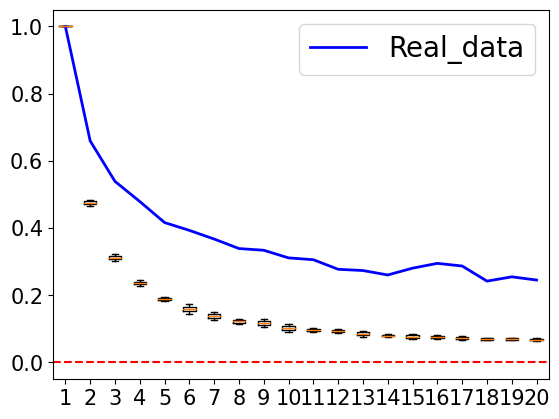

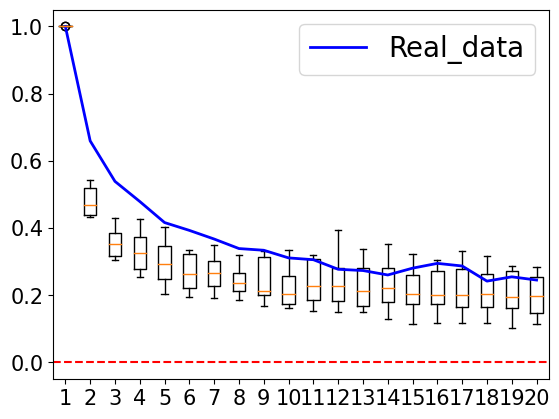

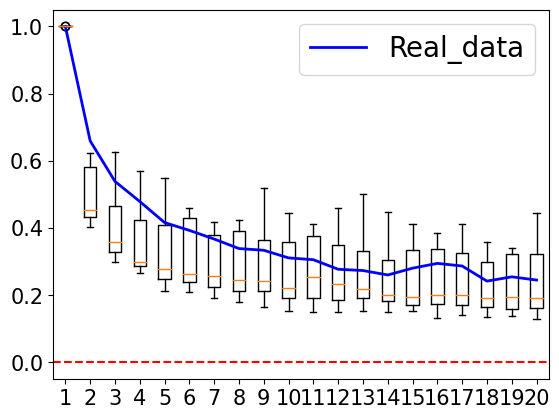

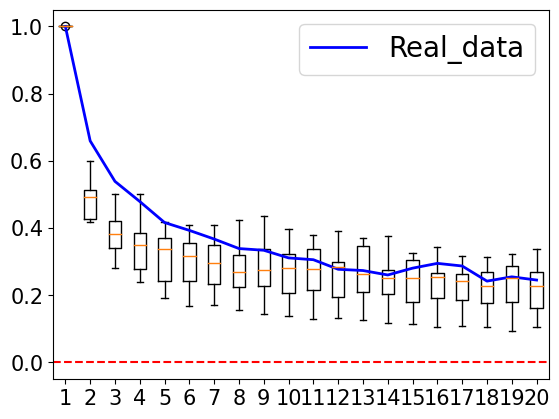

In [48]:
plot([ZI_data[0], ZI_data[2]], "volatility_cluster", "ZI", real3_data)
plot(train_mm, "volatility_cluster", "Original Train", real3_data)

plot(test_mm, "volatility_cluster", "Testing", real3_data)
plot(non_train_mm, "volatility_cluster", "Untrained", real3_data)


In [10]:
#collect data
base_path = "/home/shiftpub/sims_final/40_order_len"
train_data = []
train2_data = []
test_data = []
flash_train_data=[]
flash_test_data=[]

prev_train_data = []

for i in range(10):
    path = os.path.join(base_path, f"{i}")
    train_path =  os.path.join(path, f"iteration_info")
    train_data.append(collect_data(train_path))

    # path = os.path.join("/home/shiftpub/Smaller_LT_Size/", f"seed_{i}(t,t)(t,t)")
    # prev_train_path =  os.path.join(path, f"iteration_info")
    # prev_train_data.append(collect_data(prev_train_path))
    test_path = os.path.join(path, f"test")
    test_data.append(collect_data(test_path))
    train2_path = os.path.join(path, f"2nd_train/iteration_info")
    train2_data.append(collect_data(train2_path))
    flash_train_path = os.path.join(path, f"flash_train/iteration_info")
    flash_train_data.append(collect_data(flash_train_path))
    flash_test_path = os.path.join(path, f"flash_test")
    flash_test_data.append(collect_data(flash_test_path))



In [12]:
#Collect Real data
# base_path = "/home/shiftpub/Smaller_LT_Size/real"
# real_data = []
# folders = [folder for folder in os.listdir(base_path)]
# for folder in folders:
#     folder_path = os.path.join(base_path, folder)
#     csv_files = [file for file in os.listdir(folder_path)]
#     for file in csv_files:
#         real_data.append(pull_data(pd.read_csv(os.path.join(folder_path, file)), True))

In [11]:
#Collect Real_3 data
base_path = "/home/shiftpub/Smaller_LT_Size/real_3"
real3_data = []
csv_files = [file for file in os.listdir(base_path)]
for file in csv_files:
    real3_data.append(pull_data(pd.read_csv(os.path.join(base_path, file)), True))

In [12]:
#Collect ZI data:
base_path = "/home/shiftpub/sims_final/ZI"
ZI_data = []
for file in os.listdir(base_path):
    path = os.path.join(base_path, file)
    ZI_data.append(pull_data(pd.read_csv(path).iloc[1000:33000]))

In [13]:
#Collect new non trained data:
base_path = "/home/shiftpub/sims_final/non_train"
non_train_data = []
for file in os.listdir(base_path):
    path = os.path.join(base_path, file)
    non_train_data.append(collect_data(path))

In [14]:
train_mm = modify_mm_data(train_data) 
#prev_train_mm = modify_mm_data(prev_train_data)
train2_mm = modify_mm_data(train2_data) 
test_mm = modify_mm_data(test_data) 
flash_train_mm = modify_mm_data(flash_train_data)
flash_test_mm = modify_mm_data(flash_test_data)
non_train_mm = modify_mm_data(non_train_data)
#flash_mid_mm = modify_mm_data(flash_mid_data)

In [16]:
#print tables of "Average_Spread", "Average_Depth"
toge_statistics([train_data, train2_data, test_data, flash_train_data, flash_test_data, non_train_data], ["Average_Spread", "Average_Depth"], 
                order = ["Train", "Train2", "Test", "Flash_Train", "Flash_Test", "Non_Train"])#"Flash_Train", "Flash_Test",

Average_Spread statistics Table:
                 1      2      3      4      5      6      7      8      9     10   Mean    Std
Train        0.039  0.028  0.020  0.020  0.023  0.024  0.023  0.022  0.021  0.023  0.024  0.005
Train2       0.044  0.024  0.019  0.017  0.028  0.023  0.033  0.021  0.019  0.020  0.025  0.008
Test         0.058  0.038  0.020  0.018  0.037  0.095  0.023  0.022  0.020  0.020  0.035  0.023
Flash_Train  0.103  0.031  0.016  0.022  0.038  0.031  0.063  0.036  0.017  0.017  0.037  0.026
Flash_Test   0.018  0.028  0.018  0.026  0.023  0.016  0.031  0.027  0.016  0.019  0.022  0.005
Non_Train    0.025  0.031  0.018  0.022  0.034  0.029  0.022  0.022  0.031  0.023  0.026  0.005

Average_Depth statistics Table:
                  1      2      3      4       5      6       7      8      9     10   Mean    Std
Train        10.402  8.406  6.442  6.518   7.004  7.583   7.472  6.979  6.735  7.143  7.468  1.120
Train2       11.528  7.592  6.354  5.522   8.326  7.184   9.350 

In [17]:
#print tables of "Price_std", "Returns_Kurtosis","Average_Inventory"
toge_statistics([train_data, train2_data, test_data, flash_train_data, flash_test_data, non_train_data], ["Price_std", "Returns_Kurtosis","Average_Volume"],
                order = ["Train", "Train2", "Test", "Flash_Train", "Flash_Test", "Non_Train"])#"Flash_Train", "Flash_Test",

Price_std statistics Table:
                 1      2      3      4      5      6      7      8      9     10   Mean    Std
Train        0.297  0.108  0.063  0.059  0.128  0.131  0.098  0.078  0.079  0.054  0.110  0.068
Train2       0.277  0.086  0.078  0.041  0.107  0.058  0.194  0.075  0.086  0.085  0.109  0.068
Test         0.354  0.194  0.092  0.048  0.441  5.710  0.079  0.136  0.065  0.056  0.718  1.669
Flash_Train  1.099  0.186  0.080  0.083  0.177  0.129  1.117  0.297  0.134  0.064  0.337  0.391
Flash_Test   0.064  0.242  0.123  0.129  0.101  0.058  0.171  0.192  0.071  0.118  0.127  0.057
Non_Train    0.335  0.978  0.066  0.124  0.169  0.342  0.119  0.180  0.507  0.081  0.290  0.265

Returns_Kurtosis statistics Table:
                  1       2      3      4       5        6        7       8       9     10    Mean      Std
Train        13.370   5.202  0.386  0.580   3.671    3.819    2.439   1.437   0.610  1.273   3.279    3.700
Train2        6.831   1.324  2.909  0.465   9.85

In [18]:
def agent_plot_multi(data, type, data_class):
    if type == "reward":
        window = 100
        lt_lists = []
        mm_lists = []
        for i in range(len(data)):
            temp_lt = []
            for lt in range(len(data[i]["lt"])):
                temp_lt.append(data[i]["lt"][lt]["rew"].rolling(window).mean().dropna())
            temp_lt_avg = np.mean(temp_lt, axis=0)
            lt_lists.append(temp_lt_avg)
            temp_mm = []
            for mm in range(len(data[i]["mm"])):
                temp_mm.append(data[i]["mm"][mm]["reward"].rolling(window).mean().dropna())
            temp_mm_avg = np.mean(temp_mm, axis=0)
            mm_lists.append(temp_mm_avg)
        plt.figure(figsize=(8, 3))
        plot_percentile(lt_lists, f"{data_class} Liquidity_Taker's {type}", "blue",1)
        plt.ylabel('Reward')
        plot_percentile(mm_lists, f"{data_class} Market_Maker's {type}","red", 2)
    
    elif type == "inv_pnl":
        lt_lists = []
        mm_lists = []
        for i in range(len(data)):
            temp_lt = []
            for lt in range(len(data[i]["lt"])):
                temp_lt.append(data[i]["lt"][lt]["inv_pnl"].dropna())
            temp_lt_avg = np.mean(temp_lt, axis=0)
            lt_lists.append(temp_lt_avg)
            temp_mm = []
            for mm in range(len(data[i]["mm"])):
                temp_mm.append(data[i]["mm"][mm]["change_inven_pnl"].dropna())
            temp_mm_avg = np.mean(temp_mm, axis=0)
            mm_lists.append(temp_mm_avg)
        plt.figure(figsize=(8, 3))
        plot_percentile(lt_lists, f"{data_class} Liquidity_Taker's {type}", "blue",1)
        plt.ylabel('PnL')
        plot_percentile(mm_lists, f"{data_class} Market_Maker's {type}","red", 2)

    elif type == "cum_pnl":
        lt_lists = []
        mm_lists = []
        for i in range(len(data)):
            temp_lt = []
            for lt in range(len(data[i]["lt"])):
                temp_lt.append(data[i]["lt"][lt]["pnl"].cumsum().dropna())
            temp_lt_avg = np.mean(temp_lt, axis=0)
            lt_lists.append(temp_lt_avg)
            temp_mm = []
            for mm in range(len(data[i]["mm"])):
                temp_mm.append(data[i]["mm"][mm]["recent_pl_change"].cumsum().dropna())
            temp_mm_avg = np.mean(temp_mm, axis=0)
            mm_lists.append(temp_mm_avg)
        # plt.figure(figsize=(8, 3))
        # plot_percentile(lt_lists, f"{data_class} Liquidity_Taker's {type}", "blue",1)
        # plt.ylabel('PnL')
        # plot_percentile(mm_lists, f"{data_class} Market_Maker's {type}","red", 2)
        return(lt_lists)
    
    elif type == "inventory":
        lt_lists = []
        mm_lists = []
        for i in range(len(data)):
            temp_lt = []
            for lt in range(len(data[i]["lt"])):
                temp_lt.append(data[i]["lt"][lt]["inv"].dropna())
            temp_lt_avg = np.mean(temp_lt, axis=0)
            lt_lists.append(temp_lt_avg)
            temp_mm = []
            for mm in range(len(data[i]["mm"])):
                temp_mm.append(data[i]["mm"][mm]["current_inventory"].dropna())
            temp_mm_avg = np.mean(temp_mm, axis=0)
            mm_lists.append(temp_mm_avg)
        # plt.figure(figsize=(8, 3))
        # plot_percentile(lt_lists, f"{data_class} Liquidity_Taker's {type}", "blue",1)
        return(mm_lists)
        

    
    plt.show()

In [20]:
flash_test_data_pre = flash_test_data

In [21]:
flash_test_data = flash_test_data_pre[:7]+flash_test_data_pre[9:]

In [22]:
z = [0,1,2,3,4,5]
print(z[0:2], z[3:])

[0, 1] [3, 4, 5]


In [23]:
len(flash_test_data)

8

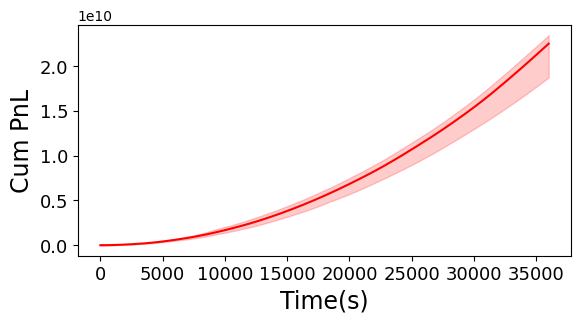

In [111]:
# #plot agent cum_pnl
# agent_plot(train_data, "cum_pnl", "Train")
# agent_plot(train2_data, "cum_pnl", "Train2")
# agent_plot(test_data, "cum_pnl", "Test")
# agent_plot(non_train_data, "cum_pnl", "Non_Train")
# agent_plot(flash_train_data, "cum_pnl", "Flash_Train")
# #agent_plot(flash_mid_data, "cum_pnl", "Flash_Mid")
# agent_plot(flash_test_data, "cum_pnl", "Flash_Test")


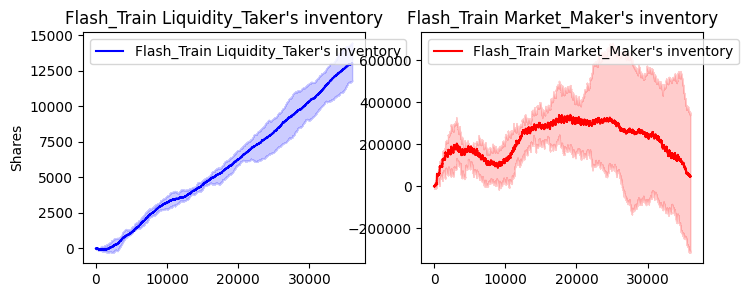

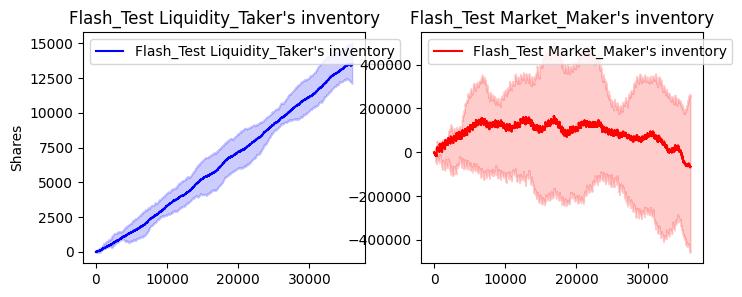

In [54]:
#plot agent inv
# agent_plot(train_data, "reward", "Train")
# agent_plot(train2_data, "reward", "Train2")
# agent_plot(test_data, "reward", "Test")
# agent_plot(non_train_data, "reward", "Non_Train")
agent_plot(flash_train_data, "inventory", "Flash_Train")
#agent_plot(flash_mid_data, "reward", "Flash_Mid")
agent_plot(flash_test_data, "inventory", "Flash_Test")

In [ ]:
#plot agent inv_pnl
agent_plot(train_data, "inv_pnl", "Train")
agent_plot(train2_data, "inv_pnl", "Train2")
agent_plot(test_data, "inv_pnl", "Test")
agent_plot(non_train_data, "inv_pnl", "Non_Train")
agent_plot(flash_train_data, "inv_pnl", "Flash_Train")
#agent_plot(flash_mid_data, "inv_pnl", "Flash_Mid")

# agent_plot(flash_test_data, "inv_pnl", "Flash_Test")


In [ ]:
#plot agent reward
# agent_plot(train_data, "reward", "Train")
# agent_plot(train2_data, "reward", "Train2")
# agent_plot(test_data, "reward", "Test")
# agent_plot(non_train_data, "reward", "Non_Train")
agent_plot(flash_train_data, "reward", "Flash_Train")
#agent_plot(flash_mid_data, "reward", "Flash_Mid")
agent_plot(flash_test_data, "reward", "Flash_Test")


In [13]:
#plot statioanry test results
plot(train_mm, "stationary_test", "Train")
plot(train2_mm, "stationary_test", "Train2")
plot(test_mm, "stationary_test", "Test")
plot(flash_train_mm, "stationary_test", "Flash_Train")
#plot(flash_test_mm, "stationary_test", "Flash_Test")
# plot(non_train_mm, "stationary_test", "Non_Train")
plot(real_data, "stationary_test", "Real")

NameError: name 'train_mm' is not defined

In [ ]:
# #plot mid prices
# plt.figure(figsize=(10, 5))
# plot(train_mm, "mid price", "Train")
# plt.figure(figsize=(10, 5))
# plot(train2_mm, "mid price", "Train2")
# plot(test_mm, "mid price", "Test")
# plot(non_train_mm, "mid price", "Non_Train")

plot(flash_train_mm, "mid price", "Flash_Train")
#plot(flash_mid_mm, "mid price", "Flash_Mid")
plot(flash_test_mm, "mid price", "Flash_Test")
# plot(real_data, "mid price", "Real")

In [ ]:
#plot return histgram
plot(train_mm, "normal dist", "Train")
plot(train2_mm, "normal dist", "Train2")
plot(test_mm, "normal dist", "Test")
plot(flash_train_mm, "normal dist", "Flash_Train")
plot(flash_test_mm, "normal dist", "Flash_Test")
plot(non_train_mm, "normal dist", "Non_Train")
# plot(real_data, "normal dist", "Real")

In [ ]:
#plot return autocorrelation
# plot(train_mm, "return autocorr", "Train")
# plot(train2_mm, "return autocorr", "Train2")
# plot(test_mm, "return autocorr", "Test")
# plot(non_train_mm, "return autocorr", "Non_Train")
plot(flash_train_mm, "return autocorr", "Flash_Train")
#plot(flash_mid_mm, "return autocorr", "Flash_Mid")

plot(flash_test_mm, "return autocorr", "Flash_Test")
#plot(real_data, "return autocorr", "Real")

In [ ]:
#plot agent moving volatility of window size 100
plot(train_mm, "volatility", "Train")
plot(train2_mm, "volatility", "Train2")
plot(test_mm, "volatility", "Test")
plot(non_train_mm, "volatility", "Non_Train")
plot(flash_train_mm, "volatility", "Flash_Train")
#plot(flash_mid_mm, "volatility", "Flash_Mid")
plot(flash_test_mm, "volatility", "Flash_Test")
# plot(real_data, "volatility", "Real")

In [ ]:
plot(train_mm, "returns statistics", "Train")
plot(train2_mm, "returns statistics", "Train2")
plot(test_mm, "returns statistics", "Test")
plot(flash_train_mm, "returns statistics", "Flash_Train")
plot(flash_test_mm, "returns statistics", "Flash_Test")
plot(non_train_mm, "returns statistics", "Non_Train")
# plot(real_data, "returns statisticsr", "Real")

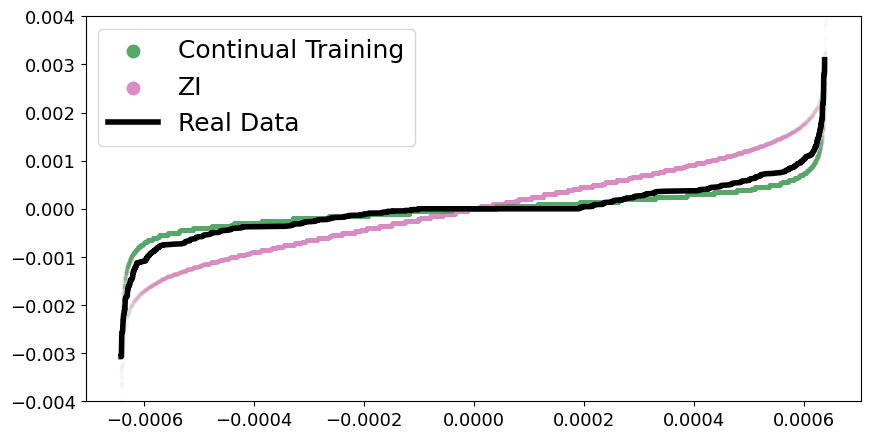

In [15]:

#plot(train_mm, "qq_plot_with_real_zi", "Train", real3_data, [ZI_data[0], ZI_data[2]],1)

plot(train_mm, "qq_plot_with_real_zi", "Train", real3_data, [ZI_data[0], ZI_data[2]],10)

# zi_data = [ZI_data[0], ZI_data[2]]
# plot(type = "qq_plot_with_all_data", dataset = [train_mm, test_mm, non_train_mm, zi_data, real3_data],
#      data_classes = ["Continual Training", "Testing", "Untrained", "ZI", "Real Data"], delta_time = 10)


#plot(train_mm, "qq_plot_with_real_zi", "Train", real3_data, [ZI_data[0], ZI_data[2]],60)


In [99]:
#print tables of "Price_std", "mm_inv_pnl","Average_Inventory"
toge_statistics([train_data, train2_data, test_data, non_train_data, [ZI_data[0], ZI_data[2]], real3_data], ["Returns_Kurtosis" ],
                order = ["Train", "Train2", "Test", "Non_Train", "ZI", "Real"])#"Flash_Train", "Flash_Test",

Returns_Kurtosis statistics Table:
                1       2      3      4       5        6      7      8       9     10    Mean      Std
Train       13.37   5.202  0.386   0.58   3.671    3.819  2.439  1.437    0.61  1.273   3.279      3.7
Train2      6.831   1.324  2.909  0.465   9.851    3.901   5.91  0.511   0.788  5.071   3.756    2.997
Test       45.434   57.93  0.866  0.215  77.559  347.286  3.876  1.239   4.106   1.55  54.006  101.446
Non_Train   3.119  15.052  0.195  2.598  97.809   26.604  0.921  0.734  17.777  3.788   16.86   28.296
ZI          0.231   1.457    nan    nan     nan      nan    nan    nan     nan    nan   0.844    0.613
Real        1.027   5.276  0.925    nan     nan      nan    nan    nan     nan    nan   2.409    2.027



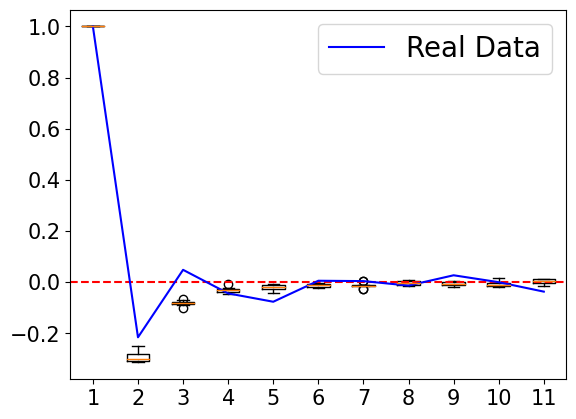

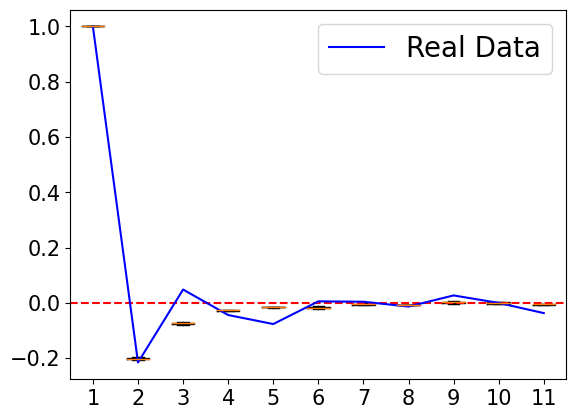

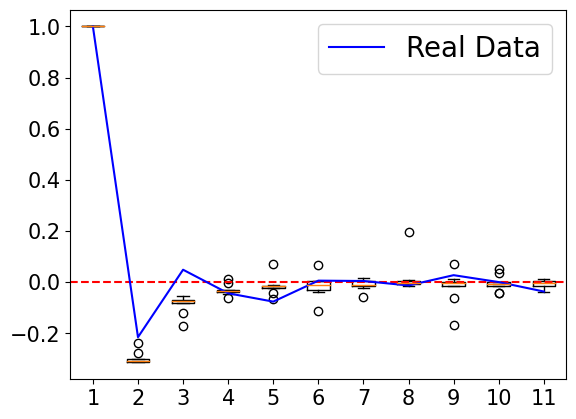

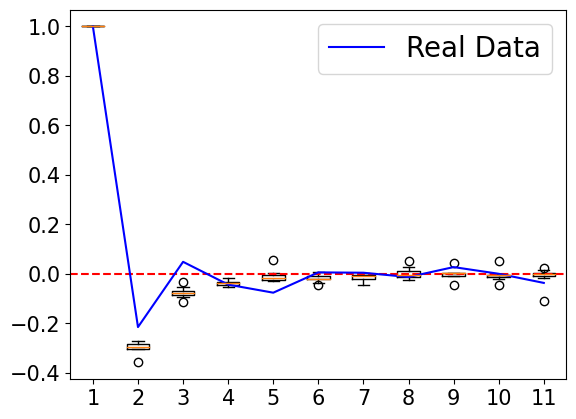

In [45]:
plt.figure()
plot(train_mm, "return autocorr", "Train2", real3_data)
plt.show()
plt.figure()
plot([ZI_data[0], ZI_data[2]], "return autocorr", "ZI", real3_data)
plt.show()
plt.figure()
plot(test_mm, "return autocorr", "Testing", real3_data)
plt.show()
plt.figure()
plot(non_train_mm, "return autocorr", "Untrained", real3_data)
plt.show()

In [ ]:
agent_plot(non_train_data, "cum_pnl_inv_pnl", "Train")


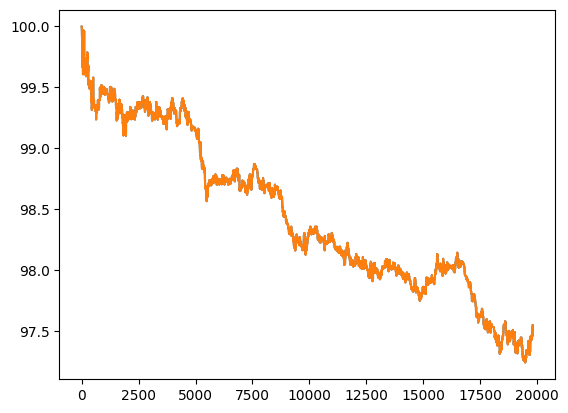

In [141]:
ratio = 100 / real3_data[0]["midprice"].iloc[0]
base_100_price = real3_data[0]["midprice"] * ratio
plt.plot(base_100_price)
plt.show()

In [21]:
def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

def plot_percentile_inventory(avgs, title, col, index, linetype, line_type = None):
    min_len = min(len(arr) for arr in avgs)
    avgs_trimmed = [arr[:min_len] for arr in avgs]
    avg = np.mean(avgs_trimmed, axis=0)
    win = 5000
    percentile_80 = moving_average(np.percentile(avgs_trimmed, 80, axis=0), win)
    percentile_20 = moving_average(np.percentile(avgs_trimmed, 20, axis=0),win)
    data = []
    for i in range(len(avgs_trimmed)):
        data.extend(avgs_trimmed[i])
    data = np.diff(data)
    # lower_bound = np.percentile(data, 5)
    # upper_bound = np.percentile(data, 95)
    # data = [value for value in data if lower_bound < value < upper_bound]

    hf_range = (percentile_80 - percentile_20)/2
    length = len(hf_range)

    #plt.plot(np.ptp(avgs_trimmed, axis=0))
    #counts, bins, _ = plt.hist(data, bins=5000, color="red", edgecolor='none',alpha=0.7,histtype='step')
    #plt.plot(bins[:-1] + 0.5 * (bins[1] - bins[0]), counts, color=col, linestyle='-', linewidth=2,label=title)
    plt.plot(moving_average(avg, win), color=col, linestyle=linetype, label=title, linewidth=2.5)

    #percentile_80, percentile_20,
    #[0]*length + hf_range, [0]*length - hf_range
    plt.fill_between(range(len(avg)-win+1), percentile_80, percentile_20, color=col, alpha=0.3, linestyle=linetype, linewidth=2.5)

def plot_percentile_inventory_change(avgs, title, col, index, linetype, line_type = None):
    min_len = min(len(arr) for arr in avgs)
    avgs_trimmed = [arr[:min_len] for arr in avgs]
    avg = np.mean(avgs_trimmed, axis=0)
    win = 5000
    percentile_80 = moving_average(np.percentile(avgs_trimmed, 80, axis=0), win)
    percentile_20 = moving_average(np.percentile(avgs_trimmed, 20, axis=0),win)
    data = []
    for i in range(len(avgs_trimmed)):
        data.extend(avgs_trimmed[i])
    data = np.diff(data)
    # lower_bound = np.percentile(data, 5)
    # upper_bound = np.percentile(data, 95)
    # data = [value for value in data if lower_bound < value < upper_bound]

    hf_range = (percentile_80 - percentile_20)/2
    length = len(hf_range)

    #plt.plot(np.ptp(avgs_trimmed, axis=0))
    #plt.hist(data, density=True, bins=5000, color="red", edgecolor='none',alpha=0.7)
    counts, bins, _ = plt.hist(data, bins=3000, density=True,color="red", edgecolor='none',alpha=0.7,histtype='step')
    plt.plot(bins[:-1] + 0.5 * (bins[1] - bins[0]), counts, color=col, linestyle=linetype, linewidth=2,label=title)
    #plt.plot(moving_average(avg, win), color=col, linestyle=linetype, label=title, linewidth=2.5)

    #percentile_80, percentile_20,
    #[0]*length + hf_range, [0]*length - hf_range
    #plt.fill_between(range(len(avg)-win+1), percentile_80, percentile_20, color=col, alpha=0.3, linestyle=linetype, linewidth=2.5)


<Figure size 1000x400 with 0 Axes>

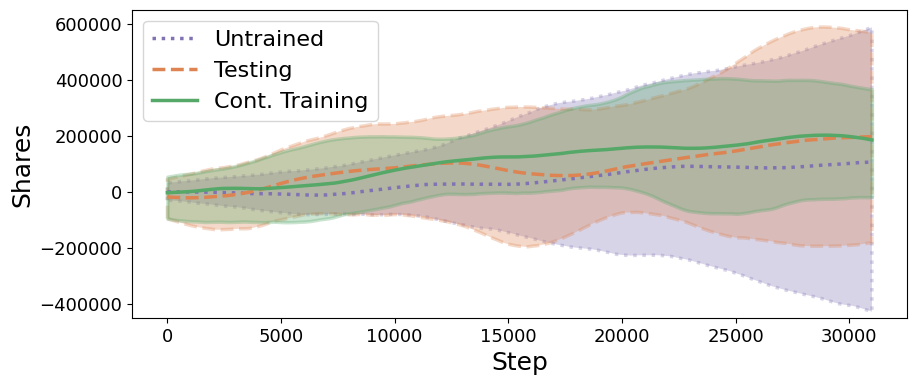

In [22]:
#plot agent inventory
#agent_plot(train_data, "inventory", "Train")
plt.figure(figsize=(10, 4)) 
color = sns.color_palette("deep")
#plot_percentile_inventory(agent_plot_multi(train_data, "inventory", "Train"), f"Original Train","green", 2)
#plt.subplot(1,2,1)

plot_percentile_inventory(agent_plot_multi(non_train_data, "inventory", "Non_Train"), f"Untrained",color[4], 2, ":")
plot_percentile_inventory(agent_plot_multi(test_data, "inventory", "Test"), f"Testing",color[1], 2, "--")
plot_percentile_inventory(agent_plot_multi(train2_data, "inventory", "Train2"), f"Cont. Training",color[2], 2, '-')

# plot_percentile(agent_plot_multi(flash_train_data, "inventory", "Flash_train"), f"Flash_train","blue", 2)
# plot_percentile(agent_plot_multi(flash_test_data, "inventory", "Flash_test"), f"Flash_test","brown", 2)

# plot_percentile(agent_plot_multi(flash_train_data, "cum_pnl", "Flash_train"), f"Flash_train","blue", 2)
# plot_percentile(agent_plot_multi(flash_test_data, "cum_pnl", "Flash_test"), f"Flash_test","brown", 2)

# agent_plot(train2_data, "inventory", "Train2")
# agent_plot(test_data, "inventory", "Test")
# agent_plot(non_train_data, "inventory", "Non_Train")
# agent_plot(flash_train_data, "inventory", "Flash_Train")
# #agent_plot(flash_mid_data, "inventory", "Flash_Mid")
# agent_plot(flash_test_data, "inventory", "Flash_Test")
plt.ylim([-450000, 650000]) 
plt.legend(fontsize=16, loc='upper left')
plt.ylabel('Shares', fontsize = 18)
plt.xlabel('Step', fontsize = 18)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

# plt.subplot(1,2,2)
# plot_percentile_inventory_change(agent_plot_multi(non_train_data, "inventory", "Non_Train"), f"Untrained",color[4], 2, ":")
# plot_percentile_inventory_change(agent_plot_multi(test_data, "inventory", "Test"), f"Testing",color[1], 2, "--")
# plot_percentile_inventory_change(agent_plot_multi(train2_data, "inventory", "Train2"), f"Continual Train",color[2], 2, '-')
# plt.xlim([-3800, 3800]) 
# plt.ylim([0, 0.0004]) 
# plt.legend(fontsize=16, loc='upper left')
# plt.ylabel('Density', fontsize = 18)
# plt.xlabel('Change in inventory per step', fontsize = 18)
# plt.xticks(fontsize = 13)
# plt.yticks(fontsize = 13)
plt.show()

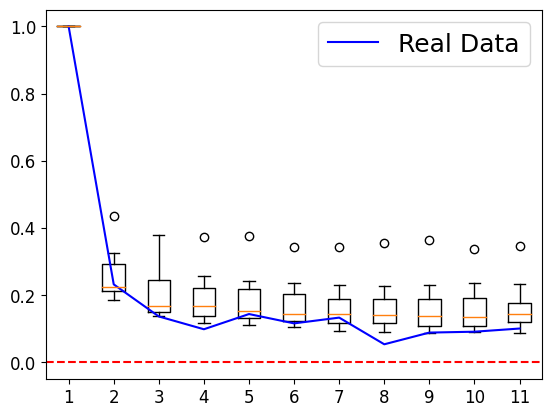

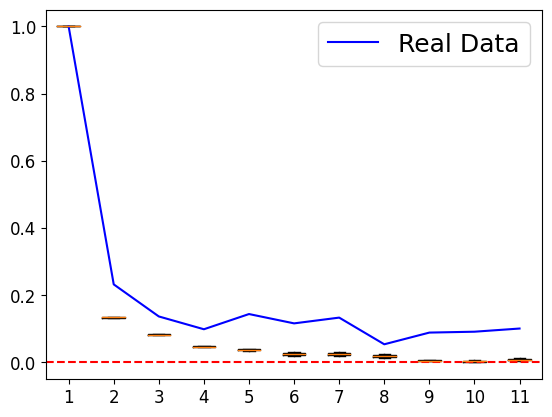

In [46]:
plot(train_mm, "return autocorr", "Group A", real3_data[0])
# plot(train2_mm, "return autocorr", "Group B", real3_data[0])
# plot(test_mm, "return autocorr", "Group C", real3_data[0])
plot(ZI, "return autocorr", "Group D", real3_data[0])


In [11]:
buy_sell_lt_mm[i]

,midprice,spread,returns,bid_volume,ask_volume,volume_inbalance
1,100.005,0.01,0.00005,73.0,73.0,0.0
2,100.005,0.01,0.00000,134.0,134.0,0.0
3,100.005,0.01,0.00000,144.0,144.0,0.0
4,100.005,0.01,0.00000,152.0,98.0,54.0
5,100.010,0.02,0.00005,153.0,63.0,90.0
...,...,...,...,...,...,...
35995,99.355,0.01,0.00000,1622.0,1421.0,201.0
35996,99.355,0.01,0.00000,1462.0,1299.0,163.0
35997,99.355,0.01,0.00000,1557.0,1394.0,163.0
35998,99.355,0.01,0.00000,1612.0,1449.0,163.0


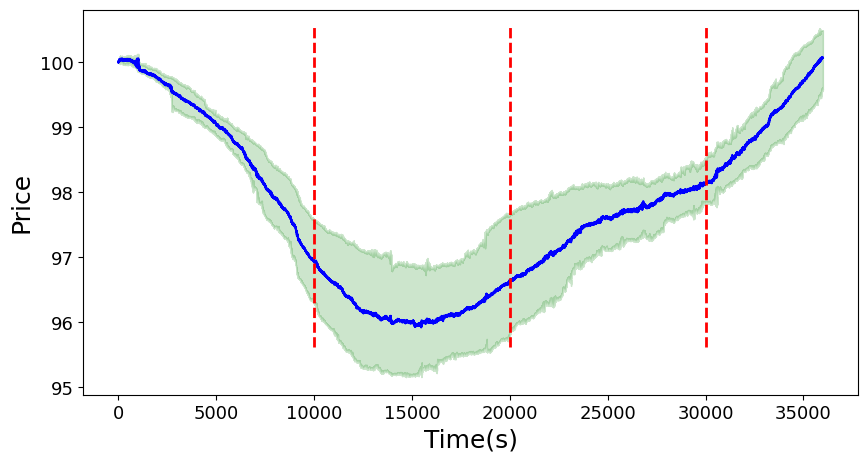

In [13]:
buy_sell_lt = []
base_path = "/home/shiftpub/sims_final/lt_info_trade/"
for i in range(5):
    path = os.path.join(base_path, f"{i}/iteration_info")
    buy_sell_lt.append(collect_data(path))
buy_sell_lt_mm = modify_mm_data(buy_sell_lt)
data1 = buy_sell_lt_mm[0]["midprice"]
price_data = []
plt.figure(figsize=(10, 5)) 
for i in range(5):
    price_data.append(buy_sell_lt_mm[i]["midprice"])

percentile_75 = np.percentile(price_data, 80, axis=0)
percentile_25 = np.percentile(price_data, 20, axis=0)

#plt.subplot(1, 2, index) 
plt.plot(np.mean(price_data, axis=0), color="blue", label="Mean Price Movement")
#plt.legend(loc='upper left', fontsize = 18)
plt.fill_between(range(len(np.mean(price_data, axis=0))), percentile_75, percentile_25, color="green", alpha=0.2)

vertical_lines_x = [10000, 20000,30000]
for line_x in vertical_lines_x:
    plt.vlines(line_x, ymin=min(data1), ymax=max(data1), colors='r', linestyles='dashed', linewidth=2, label=f'Line at x={line_x}')
#plt.title("LT with present flow of Buy/Sell fractions", fontsize = 18)
plt.xlabel('Time(s)', fontsize = 18)
plt.ylabel('Price', fontsize = 18)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.show()

In [65]:
#collect data for hyper param change:
#collect data
base_path = "/home/shiftpub/sims_final/Hyper_param_change"
all_1_tar_m_data = []
LT_MM_pnl_data = []
LT_pnl_data = []
MM_pnl_data=[]
nromal_2ndT_data=[]

for i in range(3):
    all_1_tar_m_path = os.path.join(base_path, f"all_1_tar_m/{i+1}")
    all_1_tar_m_data.append(collect_data(all_1_tar_m_path))
    LT_MM_pnl_path = os.path.join(base_path, f"LT_MM_pnl/{i+1}")
    LT_MM_pnl_data.append(collect_data(LT_MM_pnl_path))
    LT_pnl_path = os.path.join(base_path, f"LT_pnl/{i+1}")
    LT_pnl_data.append(collect_data(LT_pnl_path))
    MM_pnl_path = os.path.join(base_path, f"MM_pnl/{i+1}")
    MM_pnl_data.append(collect_data(MM_pnl_path))


In [67]:
nromal_2ndT_data=[]
#Collect nromal_2ndT_data
base_path = "/home/shiftpub/sims_final/Hyper_param_change/normal_2ndTrain"
csv_files = [file for file in os.listdir(base_path)]
for file in csv_files:
    nromal_2ndT_data.append(pull_data(pd.read_csv(os.path.join(base_path, file)), True))

In [73]:
LT_pnl_data = [LT_pnl_data[0], LT_pnl_data[2]]

In [78]:
#print tables of "Average_Spread", "Average_Depth"
toge_statistics([LT_pnl_data, MM_pnl_data, LT_MM_pnl_data, all_1_tar_m_data], ["Average_Spread", "Price_std", "Average_Depth", "Average_Volume"], 
                order = [ "LT_pnl_data", "MM_pnl_data", "LT_MM_pnl_data","all_1_tar_m_data"])#"Flash_Train", "Flash_Test",

Average_Spread statistics Table:
                      1      2      3   Mean    Std
LT_pnl_data       0.276  0.018    nan  0.147  0.129
MM_pnl_data       0.031  0.022  0.022  0.025  0.004
LT_MM_pnl_data    0.022   0.02  0.029  0.024  0.004
all_1_tar_m_data  0.028  0.023  0.008   0.02  0.008

Price_std statistics Table:
                       1      2      3    Mean    Std
LT_pnl_data       42.305  0.065    nan  21.185  21.12
MM_pnl_data        0.109   0.07  0.067   0.082  0.019
LT_MM_pnl_data     0.076  0.063  0.439   0.193  0.174
all_1_tar_m_data   0.124  0.109  0.074   0.102  0.021

Average_Depth statistics Table:
                       1      2      3   Mean    Std
LT_pnl_data       10.249  5.903    nan  8.076  2.173
MM_pnl_data        8.555  7.132  6.947  7.545  0.718
LT_MM_pnl_data     7.015  6.703   8.43  7.383  0.751
all_1_tar_m_data   8.138  7.316  4.694  6.716  1.469

Average_Volume statistics Table:
                         1         2         3      Mean      Std
LT_pnl_dat

In [10]:
#collect data
base_path = "/home/shiftpub/sims_final/flash_time"#_up

flash_train_data=[]
flash_test_data=[]
flash_ZI_data = []
flash_non_train_data=[]

flash_train_path = os.path.join(base_path, f"train")
flash_train_data.append(collect_data(flash_train_path))
flash_test_path = os.path.join(base_path, f"test")
flash_test_data.append(collect_data(flash_test_path))
flash_non_train_path = os.path.join(base_path, f"non_train")
flash_non_train_data.append(collect_data(flash_non_train_path))

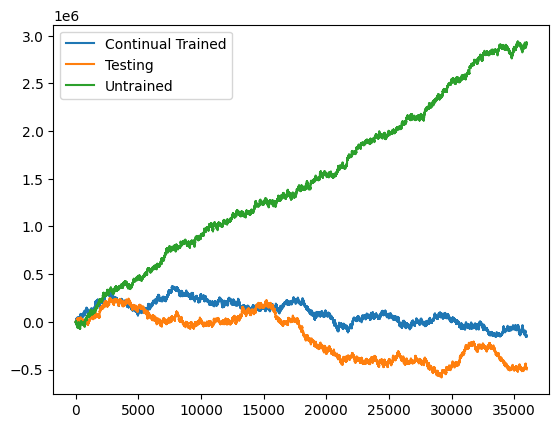

In [29]:
plt.plot(flash_train_data[0]["mm"][0]["current_inventory"], label = "Continual Trained")
plt.plot(flash_test_data[0]["mm"][0]["current_inventory"], label = "Testing")
plt.plot(flash_non_train_data[0]["mm"][0]["current_inventory"], label = "Untrained")
plt.legend(loc = "upper left")
plt.show()

In [11]:
agent_plot(flash_train_data, "inventory", "Flash_Train")


/home/shiftpub/miniconda/envs/sep_rlsim/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shiftpub/miniconda/envs/sep_rlsim/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: object of type 'numpy.float64' has no len()